# Kidney Stone Classication using CT_Images


## Importing Libraries


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import gradio as gr

2024-10-08 20:26:31.153262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 20:26:31.167175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 20:26:31.282115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 20:26:31.397547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 20:26:31.493709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Preparing Traning Data


In [2]:
folder_path = "./CT_images/Train/"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,Normal/Normal- (2004).jpg,Normal
1,Normal/Normal- (2160).jpg,Normal
2,Normal/Normal- (928).jpg,Normal
3,Normal/Normal- (554).jpg,Normal
4,Normal/Normal- (430).jpg,Normal


In [4]:
df.tail()

,filename,category
2995,Stone/Stone- (857).jpg,Stone
2996,Stone/Stone- (933).jpg,Stone
2997,Stone/Stone- (787).jpg,Stone
2998,Stone/Stone- (177).jpg,Stone
2999,Stone/Stone- (290).jpg,Stone


<Axes: xlabel='category'>

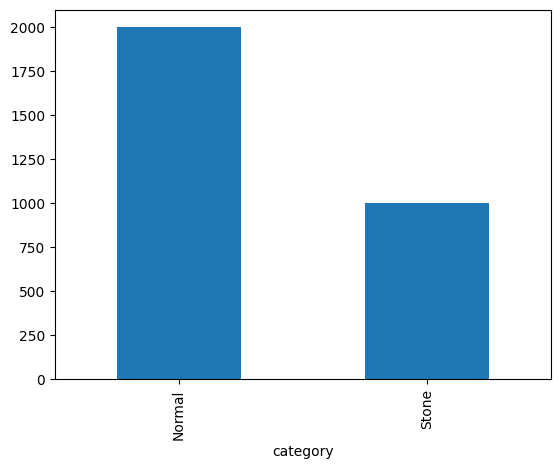

In [5]:
df['category'].value_counts().plot.bar()

We have 3000 total images (2000 Normal, 1000 Stone)


## Visualizing Data


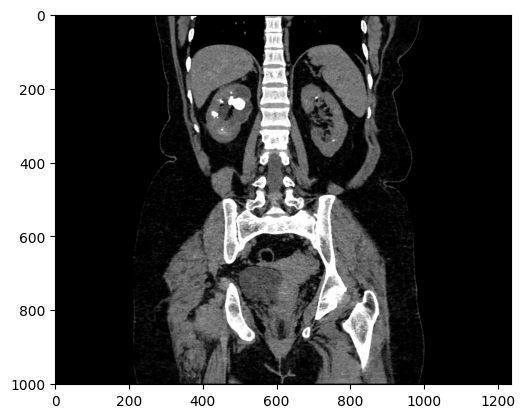

In [6]:
sample = random.choice(filenames)
image = load_img("./CT_images/Train/"+sample)
plt.imshow(image)

# CNN(Convolutional Neural Network)


## Building CNN Model


In [7]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

/home/huz/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728401208.195631   10014 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-08 20:26:48.196513: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs


#### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased


In [9]:
earlystop = EarlyStopping(patience=10)

#### Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps


In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data


In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

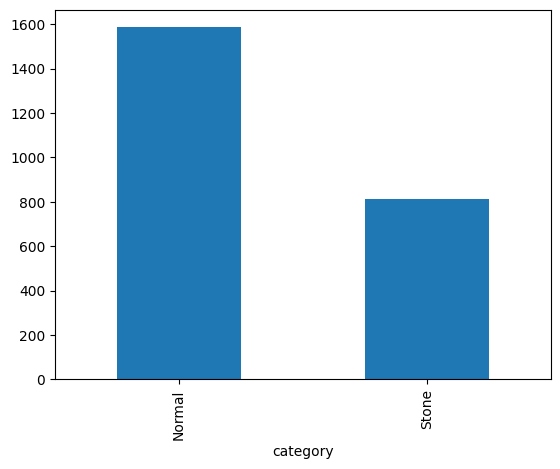

In [13]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

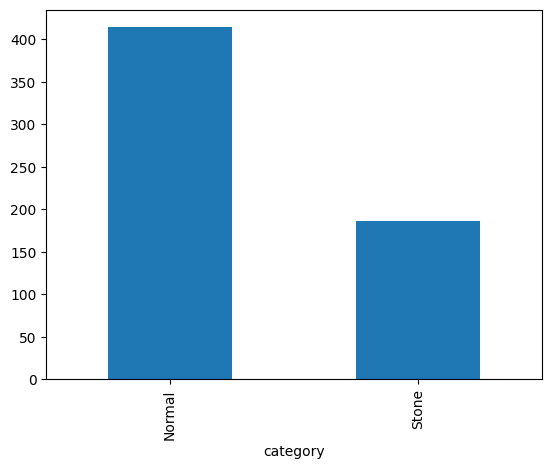

In [14]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./CT_images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./CT_images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


### Visulaizing the output of data gen


In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./CT_images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


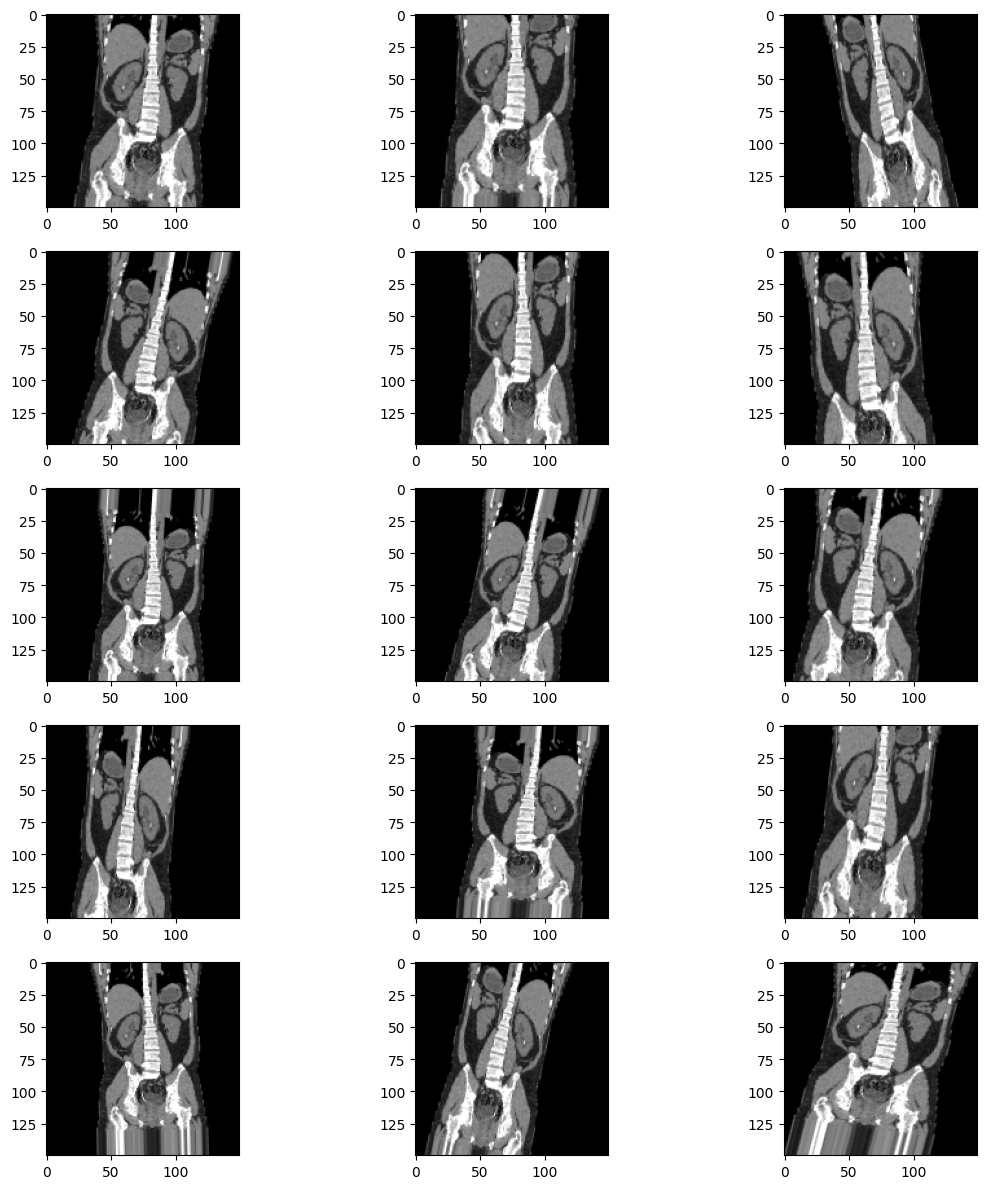

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model


In [19]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

/home/huz/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.6712 - loss: 0.6781 - val_accuracy: 0.3533 - val_loss: 3.3196 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


2024-10-08 20:28:07.475621: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-08 20:28:07.483687: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/huz/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/home/huz/.local/lib/python3.10/site-packages/keras/src/callbacks

160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.8346 - loss: 0.4008 - val_accuracy: 0.4650 - val_loss: 4.7794 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50


2024-10-08 20:28:51.271356: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.8677 - loss: 0.3432 - val_accuracy: 0.8500 - val_loss: 0.2953 - learning_rate: 0.0010
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - accuracy: 0.8860 - loss: 0.2827 - val_accuracy: 0.8583 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 80us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50


2024-10-08 20:30:20.035816: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - accuracy: 0.8851 - loss: 0.2760 - val_accuracy: 0.8983 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - accuracy: 0.8915 - loss: 0.2683 - val_accuracy: 0.8517 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9154 - loss: 0.2354
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - accuracy: 0.9153 - loss: 0.2354 - val_accuracy: 0.8983 - val_loss: 0.2701 - learning_rate: 0.0010
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 15/50
160/160 ━━━━━━

2024-10-08 20:33:16.673381: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.9413 - loss: 0.1584 - val_accuracy: 0.8950 - val_loss: 0.2603 - learning_rate: 5.0000e-04
Epoch 18/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 19/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9318 - loss: 0.1712
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.9318 - loss: 0.1712 - val_accuracy: 0.9183 - val_loss: 0.1525 - learning_rate: 5.0000e-04
Epoch 20/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 21/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 278ms/step - accuracy: 0.9304 - loss: 0.1616 - val_accuracy: 0.9800 - val_loss: 0.0539 - learning_rate: 2.5000e-04
Epoch 22/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 

2024-10-08 20:39:02.551170: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 294ms/step - accuracy: 0.9590 - loss: 0.1172 - val_accuracy: 0.9850 - val_loss: 0.0347 - learning_rate: 6.2500e-05
Epoch 34/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 35/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 278ms/step - accuracy: 0.9483 - loss: 0.1276 - val_accuracy: 0.9700 - val_loss: 0.0495 - learning_rate: 6.2500e-05
Epoch 36/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 37/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9563 - loss: 0.1185
Epoch 37: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 287ms/step - accuracy: 0.9563 - loss: 0.1184 - val_accuracy: 0.9600 - val_loss: 0.0647 - learning_rate: 6.2500e-05
Epoch 38/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 69us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 

### Visualizing the Training history


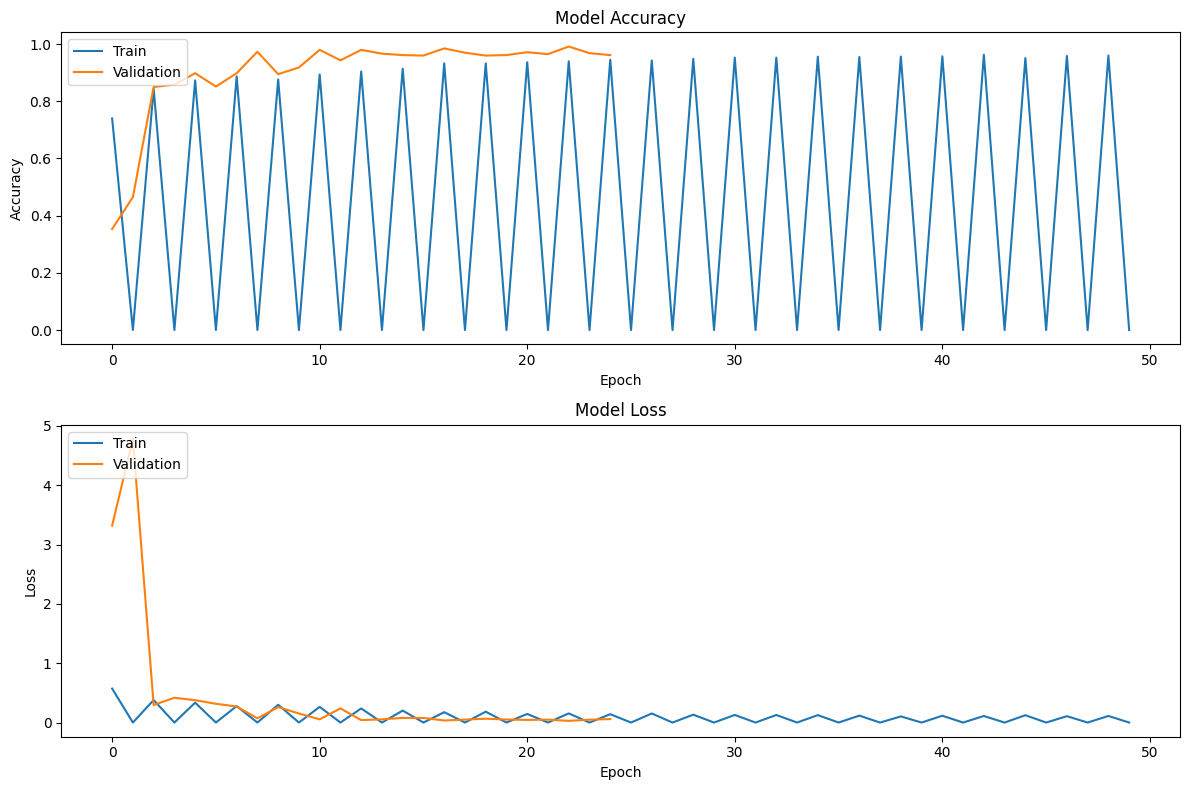

In [21]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model


In [22]:
# Saving the Model
model.save('kidney_stone_detection_model.h5')

### Testing Data


In [24]:
test_folder_path = "./CT_images/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./CT_images/Test/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions


In [28]:
steps = int(np.ceil(test_df.shape[0] / 15))

predict = model.predict(test_generator, steps=steps)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


In [29]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [30]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [31]:
test_df.head()

,filename,category,predicted category
0,Stone/Stone- (1282).jpg,Stone,Stone
1,Stone/Stone- (1165).jpg,Stone,Stone
2,Stone/Stone- (1001).jpg,Stone,Stone
3,Stone/Stone- (1220).jpg,Stone,Stone
4,Stone/Stone- (1092).jpg,Stone,Normal


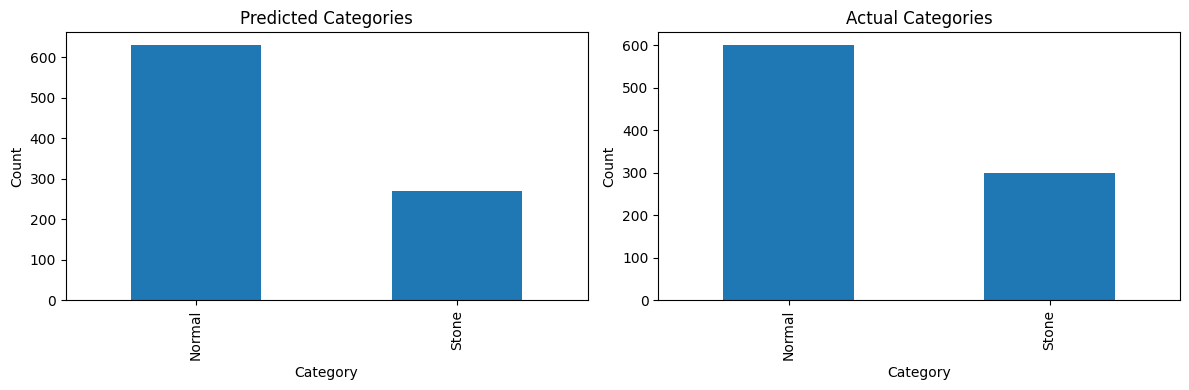

In [32]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

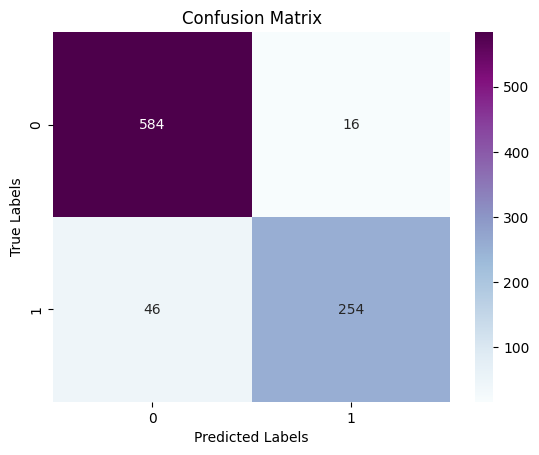

In [33]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images


In [34]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8891 - loss: 0.2778


[0.16409043967723846, 0.9311110973358154]

# SVM


In [13]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images_list.append(img)
    return images_list

In [14]:
#Reading train images from the normal and stone folders
train_normal = read_images('CT_images/Train/Normal')
train_stone = read_images('CT_images/Train/Stone')

In [15]:
#Creating a list of labels for training 
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [16]:
#Defining a function for HOG feature extraction
def extract_features(images):
    feature_list = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                            cells_per_block=(1, 1), visualize=True, channel_axis=2)
        # Resize the HOG features to a fixed size
        fd = np.resize(fd, (2400, 1))
        # Flatten the array to 2 dimensions
        fd = fd.flatten()
        feature_list.append(fd)
    return feature_list

In [17]:
#Extracting the HOG features from both normal and stone images
feature_list_normal = extract_features(train_normal)
feature_list_stone = extract_features(train_stone)

In [18]:
print(len(feature_list_normal))
print(len(feature_list_stone))

2000
1000


In [19]:
#Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [20]:
#Reading test images from the normal and stone folders
test_normal = read_images('CT_images/Test/Normal')
test_stone = read_images('CT_images/Test/Stone')

In [21]:
#Creating a list of labels for testing 
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [22]:
#Creating a Feature Vector for Test Set
test_feature_list_normal = extract_features(test_normal)
test_feature_list_stone = extract_features(test_stone)

In [23]:
print(len(test_feature_list_normal))
print(len(test_feature_list_stone))

600
300


In [24]:
#Combining the features for both classes
test_features = test_feature_list_normal + test_feature_list_stone

In [25]:
#Splitting the data into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=0)

In [26]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(2400,)
(2400,)
(2400,)


In [27]:
# Training a SVM Model
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train, y_train)

SVC(C=1, gamma='auto')

In [28]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [29]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.7966666666666666


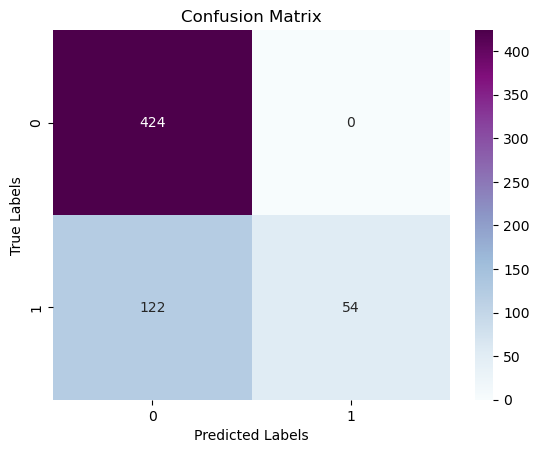

In [133]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

Same case is with the SVM it is also baised towrads the Normal


In [130]:
import sklearn.externals
import joblib

# Save the model to a file
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

# GUI


## If you dont want to train the models you can load the models which I have already trained otherwise you can skip these loading models cell and directly run the GUI


In [35]:
from keras.models import load_model
model = load_model('kidney_stone_detection_model.h5')

In [36]:
import sklearn.externals
import joblib
svc = joblib.load("svc.pkl") 

/home/huz/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Custom tkinter GUI


In [37]:
# Function to Select Image
def browse_btn():
    global image_name
    
    label_cnn.configure(text="")
    label.configure(text="")
    
    image_name = askopenfilename(title='Select Image')
    img = Image.open(image_name)
    img = img.resize((200, 200), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel = tk.Label(root, image=img)
    panel.image = img
    panel.grid(row=0,column=1,sticky='nw',padx=20,pady=28)

In [38]:
# Function to Predict CNN
def predict_btn_cnn():
    global label_prediction
    global image_name
    test_img = image.load_img(image_name, target_size=(150, 150))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    result = model.predict(test_img)
    if result[0][0] == 1:
        label_cnn.configure(text="Kidney Stone Detected")
    elif result[0][0] == 0:
        label_cnn.configure(text="No Kidney Stone Detected")

In [39]:
#Function for Predict SVM        
def predict_btn_svm():
    global label_prediction
    global image_name
    test_img = cv2.imread(image_name)
    #test_img = image.load_img(image_name, target_size=(150, 150))
    #test_img = image.img_to_array(test_img)
    feature_list_of_img = extract_features([test_img])
    result = svc.predict(feature_list_of_img)    
    #Displaying the output
    if result[0] == 'Stone':
        label.configure(text = "Kidney Stone Detected")
    elif result[0] == 'Normal':
        label.configure(text = "No Kidney Stone Detected")

In [49]:
# Creating the GUI
from tkinter import *
from PIL import Image, ImageTk
import customtkinter
import tkinter
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfilename
from tkinter import messagebox
import keras.utils as image
import numpy as np
import os

customtkinter.set_appearance_mode("System")
root = customtkinter.CTk()

#window size
root.rowconfigure(0,weight=1)    
root.columnconfigure(0,weight=1)

root.geometry('420x380')
root.title('Kidney Stone Detection')
        
# Browse Button
browsebtn = customtkinter.CTkButton(master=root, text="Browse Image", command=browse_btn)
browsebtn.grid(row=0, column=0,sticky='nw',padx=20,pady=20)


# Predict Butoon CNN
predictbtn = customtkinter.CTkButton(master=root, text="Predict CNN", command=predict_btn_cnn)
predictbtn.grid(row=1, column=0,sticky='nw',padx=20,pady=20)

#Label Result CNN
label_cnn = customtkinter.CTkLabel(root, text="")
label_cnn.grid(row=1,column=1,sticky='nw',padx=20,pady=20)

#Label Result SVM
label = customtkinter.CTkLabel(root, text="")
label.grid(row=2,column=1,sticky='nw',padx=20,pady=20)
# Predict Butoon SVM
predictbtnsvm = customtkinter.CTkButton(master=root, text="Predict SVM", command=predict_btn_svm)
predictbtnsvm.grid(row=2, column=0,sticky='nw',padx=20,pady=20)

# Running the GUI
root.mainloop()

invalid command name "128473621323392update"
    while executing
"128473621323392update"
    ("after" script)
invalid command name "128472940071872check_dpi_scaling"
    while executing
"128472940071872check_dpi_scaling"
    ("after" script)
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 9, in browse_btn
    img = Image.open(image_name)
  File "/home/huz/.local/lib/python3.10/site-packages/PIL/Image.py", line 3431, in open
    fp = builtins.open(filename, "rb")
IsADirectoryError: [Errno 21] Is a directory: '/home/huz/Stuff/cui/F/Eisha/fyp/Kidney-Stone-Detection-main'
Exception in Tkinter callback[ WARN:0@5911.982] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity

Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/444933335.py", line 8, in predict_btn_svm
    feature_list_of_img = extract_features([test_img])
NameError: name 'extract_features' is not defined
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'
Exception in Tkinter callb

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/home/huz/.local/lib/python3.10/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_10014/2586483366.py", line 10, in browse_btn
    img = img.resize((200, 200), Image.ANTIALIAS)
AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0.089397006


## Gradio APP


In [50]:
def custom_Image_preprocessing(image_data, target_size=(150, 150)):
    img = image.array_to_img(image_data, data_format='channels_last')
    img = img.resize(target_size)  # Resize the image if needed
    img_arr = image.img_to_array(img)
    img_arr = img_arr * 1./255
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

In [51]:
# Function to Predict CNN
def predict(img):
    image_preprocess = custom_Image_preprocessing(img)
    result = model.predict(image_preprocess)
    print(result[0][0])
    if result[0][0] > 0.5:
        return 'Kidney Stone Detected (Positive)',round(result[0][0]*100,2),'%'
    else:
        return 'No Kidney Stone Detected  (Negative)',round(result[0][0]*100,2),'%'

In [52]:
# Create a Gradio interface
input_component =  gr.components.Image(label = "Upload the CT-Image")
output_component = gr.components.Textbox(label = "Prediction")

iface = gr.Interface(
    fn=predict,
    inputs=input_component, 
    outputs=output_component,
    title = "Kidney Stone Classification",
    description="This web app provides predictions based on CT-images and predict either the CT-Scan  contains sympotms of Kidney stone or not "
)

iface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0.0039200783
